Adding Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import re


Getting the Data frame ready:

In [2]:
drivers_2019 = pd.read_csv("Data/2019_drivers.csv")
drivers_2019["Year"] = 2019
drivers_2020 = pd.read_csv("Data/2020_drivers.csv")
drivers_2020["Year"] = 2020
drivers_2021 = pd.read_csv("Data/2021_drivers.csv")
drivers_2021["Year"] = 2021
drivers_2022 = pd.read_csv("Data/2022_drivers.csv")
drivers_2022["Year"] = 2022
drivers_2023 = pd.read_csv("Data/2023_drivers.csv")
drivers_2023["Year"] = 2023
drivers_2024 = pd.read_csv("Data/2024_drivers.csv")
drivers_2024["Year"] = 2024

all_drivers = pd.concat([drivers_2019, drivers_2020, drivers_2021, drivers_2022, drivers_2023, drivers_2024], axis = 0)

all_drivers
all_drivers.drop(columns=["Driver", "Highest Race Finish",  "Date of Birth", "Place of Birth", "Abbreviation"],inplace = True)
all_drivers


all_drivers["Number"] = all_drivers["Number"].fillna(all_drivers["No"])
all_drivers
all_drivers.drop(columns=["No"],inplace = True)


all_drivers["Podium Percentage"] = all_drivers["Podiums"] / all_drivers["Grands Prix Entered"]
all_drivers.head()

all_drivers["Has WC"] = np.where(all_drivers["World Championships"] > 0, 1, 0)
all_drivers.head()

,Number,Team,Country,Podiums,Points,Grands Prix Entered,World Championships,Highest Grid Position,Year,Podium Percentage,Has WC
0,44.0,Mercedes,United Kingdom,151,3431.0,250,6,1,2019,0.604000,1
1,77.0,Mercedes,Finland,45,1289.0,140,0,1,2019,0.321429,0
2,33.0,Red Bull Racing,Netherlands,31,948.0,102,0,1,2019,0.303922,0
3,16.0,Ferrari,Monaco,10,303.0,42,0,1,2019,0.238095,0
4,5.0,Ferrari,Germany,120,2985.0,241,4,1,2019,0.497925,1


In [3]:
raceRes19 = pd.read_csv("Data/2019_raceResults.csv")
raceRes19["Year"] = 2019
raceRes20 = pd.read_csv("Data/2020_raceResults.csv")
raceRes20["Year"] = 2020
raceRes21 = pd.read_csv("Data/2021_raceResults.csv")
raceRes21["Year"] = 2021
raceRes22 = pd.read_csv("Data/2022_raceResults.csv")
raceRes22["Year"] = 2022
raceRes23 = pd.read_csv("Data/2023_raceResults.csv")
raceRes23["Year"] = 2023
raceRes24 = pd.read_csv("Data/2024_raceResults.csv")
raceRes24["Year"] = 2024

#finding all of the unique races in 2021
unique_races_21 = raceRes21["Track"].unique()

#setting the fastest lap of those who did not complete a lap 100 minutes to make sure they do not count 
raceRes21["Fastest Lap"] = raceRes21["Fastest Lap"].fillna("100:0.0")
#creating a new variable called "Set Fastest Lap" and setting it by default to "No"
raceRes21["Set Fastest Lap"] = "No"

#Making a functrion that will take the string time that a driver set for their fastest lap and returning it in milliseconds 
def time_to_sec(time):
    # Split into minutes and "seconds.milliseconds"
    minutes, sec_millis = time.split(":")  
    # Split seconds and milliseconds
    seconds, milliseconds = sec_millis.split(".")  
        
    # Convert all parts to integers
    total_ms = (int(minutes) * 60 + int(seconds)) * 1000 + int(milliseconds)

    #returning the total miliseconds 
    return total_ms

#for each track in the 2021 season we find the minimum time, aka the fastest lap and we check it with all of the lap times and set "Set Fastest Lap" to "Yes" or "No"
for i in range(0,len(unique_races_21)):
    track_subset = raceRes21[raceRes21["Track"] == unique_races_21[i]]
    #finding minimum value 
    fastest_time = min(track_subset['Fastest Lap'])

    #setting Yes or No to each track for "Set fastest Lap"
    raceRes21.loc[raceRes21["Track"] == unique_races_21[i], "Set Fastest Lap"] = raceRes21.loc[raceRes21["Track"] == unique_races_21[i], "Fastest Lap"].apply(lambda x: "Yes" if x == fastest_time else "No")


#repeating the process as we did for 2021, but for the 2022 season
raceRes22["Fastest Lap"] = raceRes22["Fastest Lap"].fillna("100:0.0")
raceRes22["Set Fastest Lap"] = "No"

#finding all of the unique races in 2021
unique_races_22 = raceRes22["Track"].unique()

#for each track in the 2021 season we find the minimum time, aka the fastest lap and we check it with all of the lap times and set "Set Fastest Lap" to "Yes" or "No"
for i in range(0,len(unique_races_22)):
    track_subset = raceRes21[raceRes22["Track"] == unique_races_22[i]]
    fastest_time = min(track_subset['Fastest Lap'])

    #setting Yes or No to each track for "Set fastest Lap"
    raceRes22.loc[raceRes22["Track"] == unique_races_22[i], "Set Fastest Lap"] = raceRes22.loc[raceRes22["Track"] == unique_races_22[i], "Fastest Lap"].apply(lambda x: "Yes" if x == fastest_time else "No")


#Setting the fastest lap column to equal the set fastest lap column, as we won't use it in the future
raceRes21["Fastest Lap"] = raceRes21["Set Fastest Lap"]
raceRes22["Fastest Lap"] = raceRes22["Set Fastest Lap"]


#Concatenating all of the different datasets we have for our races
all_races = pd.concat([raceRes19, raceRes20, raceRes21, raceRes22, raceRes23, raceRes24], axis = 0)


#need to merge total time/gap with time/req & need to merge fastest lap with set fastest lap
all_races["Time/Retired"] = all_races["Time/Retired"].fillna(all_races["Total Time/Gap/Retirement"])
all_races["Fastest Lap"] = all_races["Fastest Lap"].fillna(all_races["Set Fastest Lap"])

all_races.drop(columns = ["Driver", "Laps", "Total Time/Gap/Retirement", "Set Fastest Lap", "+1 Pt", "Fastest Lap Time"], inplace = True)

all_races = all_races[(all_races["Position"] != "DQ") & (all_races["Position"] != "NC")]
all_races = all_races.dropna()

all_races["Position"] = all_races["Position"].astype(int)
all_races["Starting Grid"] = all_races["Starting Grid"].astype(int)

all_races["Net Position"] = all_races["Starting Grid"] - all_races["Position"]

all_races.head()



,Track,Position,No,Team,Starting Grid,Points,Fastest Lap,Year,Time/Retired,Net Position
0,Australia,1,77,Mercedes,2,26.0,Yes,2019,1:25:27.325,1
1,Australia,2,44,Mercedes,1,18.0,No,2019,+20.886,-1
2,Australia,3,33,Red Bull Racing Honda,4,15.0,No,2019,+22.520,1
3,Australia,4,5,Ferrari,3,12.0,No,2019,+57.109,-1
4,Australia,5,16,Ferrari,5,10.0,No,2019,+58.230,0


Starting K-Means Clustering to try and categorize the driver's into performance groups:

For this, we will use the K-means functions from the sklearn library, it is included above, where pandas and numpy are included.

For our clustering we will use the driver's average lap time, number of pole positions, and their podium percentage to try to cluster the drivers.
We will try to find the best number of clusters using the Elbow method.

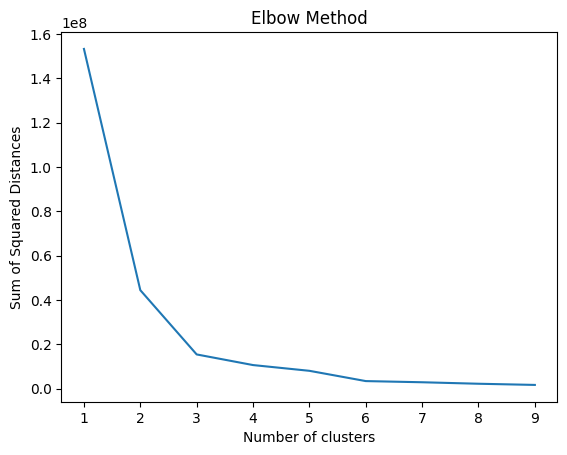

In [4]:
#we will select, from the all_drivers dataset, the variables 'Podium Percentage', 'Points', and 'Highest Grid Position'
selected_data = all_drivers[['Podium Percentage', 'Points', 'Highest Grid Position']]

#making a variable that will hold the Sum of Squared Distances 
SSD = []
#Finding the best number of cluseters from 1 to 10
for i in range(1, 10):
    #making the number of clusters in a variable called 'kmeans'
    kmeans = KMeans(n_clusters = i, max_iter = 250, random_state = 0)
    #fitting the selected data from all_drivers to our kmeans model made above.
    kmeans.fit(selected_data)
    #adding the square distance to SSD
    SSD.append(kmeans.inertia_)

#Plotting the graph for the elbow method to find the best number of clusters 
plt.plot(range(1, 10), SSD)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

Based on the Elbow graph above, we see that a number of clusters equal to 3 seems to be ideal for us. This should make sure that we do not over fit our model.

Let's see how k-means with a k = 3 will cluster our data:

In [5]:
#making a kmeans model with the best number of clusters, which is 3
best_kmeans = KMeans(n_clusters = 3, max_iter = 250, random_state = 0)
#Predicting the class of our data with the best number of clusters 
class_ = best_kmeans.fit_predict(selected_data)

#Adding a new column to all_drivers and setting our predicted classes
all_drivers['Cluster'] = class_
all_drivers.head()



,Number,Team,Country,Podiums,Points,Grands Prix Entered,World Championships,Highest Grid Position,Year,Podium Percentage,Has WC,Cluster
0,44.0,Mercedes,United Kingdom,151,3431.0,250,6,1,2019,0.604000,1,2
1,77.0,Mercedes,Finland,45,1289.0,140,0,1,2019,0.321429,0,0
2,33.0,Red Bull Racing,Netherlands,31,948.0,102,0,1,2019,0.303922,0,0
3,16.0,Ferrari,Monaco,10,303.0,42,0,1,2019,0.238095,0,1
4,5.0,Ferrari,Germany,120,2985.0,241,4,1,2019,0.497925,1,2


Here we can see our kmeans algorithm has partitioned our clusters into 3 groups. We used the variables Podium Percentage, Points, and Highest Grid Position to partition the drivers into 3 seperate classes that would allow us to see how good of a driver they are: high class, medium class, and low class driver.

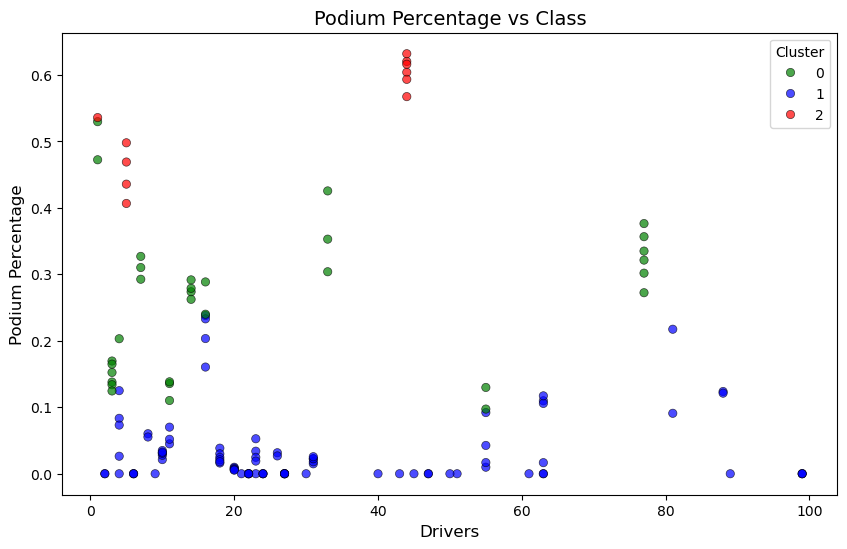

In [6]:
plt.figure(figsize=(10, 6))

all_drivers["Cluster"] = all_drivers["Cluster"].astype("category")

sns.scatterplot(data=all_drivers, x="Number", y="Podium Percentage", alpha=0.7, edgecolor="black", hue = "Cluster", palette={0: "green", 1: "blue", 2: "red"})

# Labels and title
plt.title("Podium Percentage vs Class", fontsize=14)
plt.xlabel("Drivers", fontsize=12)
plt.ylabel("Podium Percentage", fontsize=12)

# Show the plot
plt.show()

From this graph we can see that a cluster value of 0 corresponds to the lower class (color blue), 1 corresponds to the middle class (color green), 2 corresponds to the higher class (color red)

/var/folders/l_/7jk3kgwj03b5gs05k2fpbrsh0000gn/T/ipykernel_27121/3669903794.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_cluster_counts = unique_drivers.groupby(["Country", "Cluster"]).size().unstack(fill_value=0)


<Figure size 1200x600 with 0 Axes>

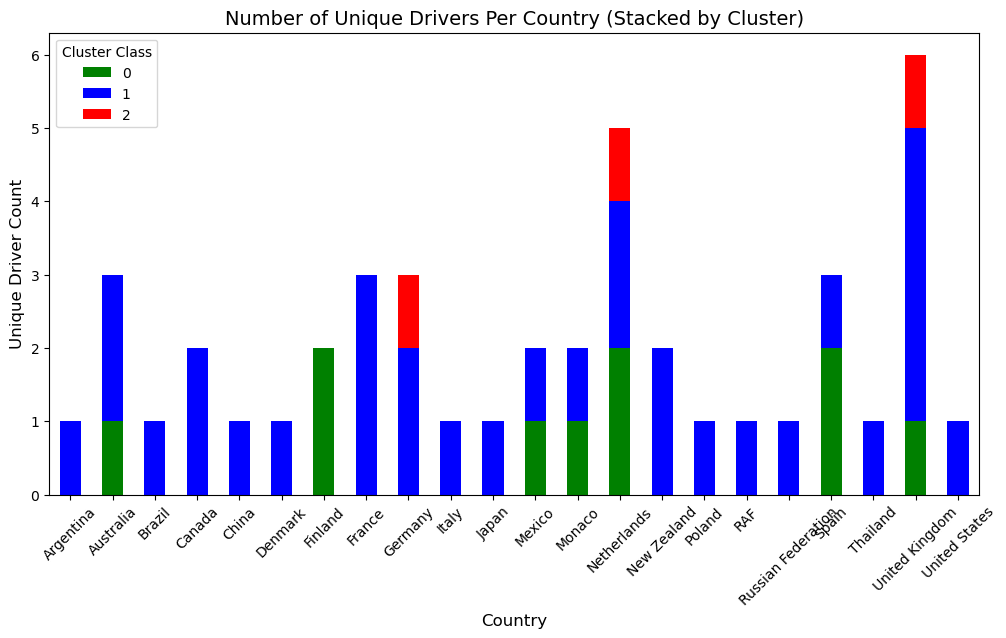

In [25]:
# data cleaning to remove typo
all_drivers = all_drivers[all_drivers["Country"] != "Sapin"]
# Step 1: Remove duplicates only when both "Number" and "Cluster" match
unique_drivers = all_drivers.drop_duplicates(subset=["Number", "Cluster"])

# Step 2: Count unique drivers per country and per cluster
country_cluster_counts = unique_drivers.groupby(["Country", "Cluster"]).size().unstack(fill_value=0)

# Step 3: Plot stacked bar chart
plt.figure(figsize=(12, 6))
colors = {0: "green", 1: "blue", 2: "red"}  # Custom color mapping
country_cluster_counts.plot(kind="bar", stacked=True, 
                            color=[colors[c] for c in country_cluster_counts.columns], 
                            figsize=(12, 6))

# Labels and title
plt.title("Number of Unique Drivers Per Country (Stacked by Cluster)", fontsize=14)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Unique Driver Count", fontsize=12)
plt.xticks(rotation=45)  # Rotate for readability
plt.legend(title="Cluster Class")

# Show the plot
plt.show()

This here shows the distribtion of driver class across each country. We made sure to remove any duplicates where drivers were in the same class across multiple years. However, we included when the same driver appeared in multiple classes over different years. We can see that only Germany, Netherlands, and the United Kingdom has produced high class drivers. We also see that Finland has only ever produced low class drivers. Some other countries that produced middle class drivers are Australia, Canada, France, United Kingdom, and New Zealand. 

/var/folders/l_/7jk3kgwj03b5gs05k2fpbrsh0000gn/T/ipykernel_27121/2363117780.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  team_cluster_counts = unique_drivers.groupby(["Team", "Cluster"]).size().unstack(fill_value=0)


<Figure size 1200x600 with 0 Axes>

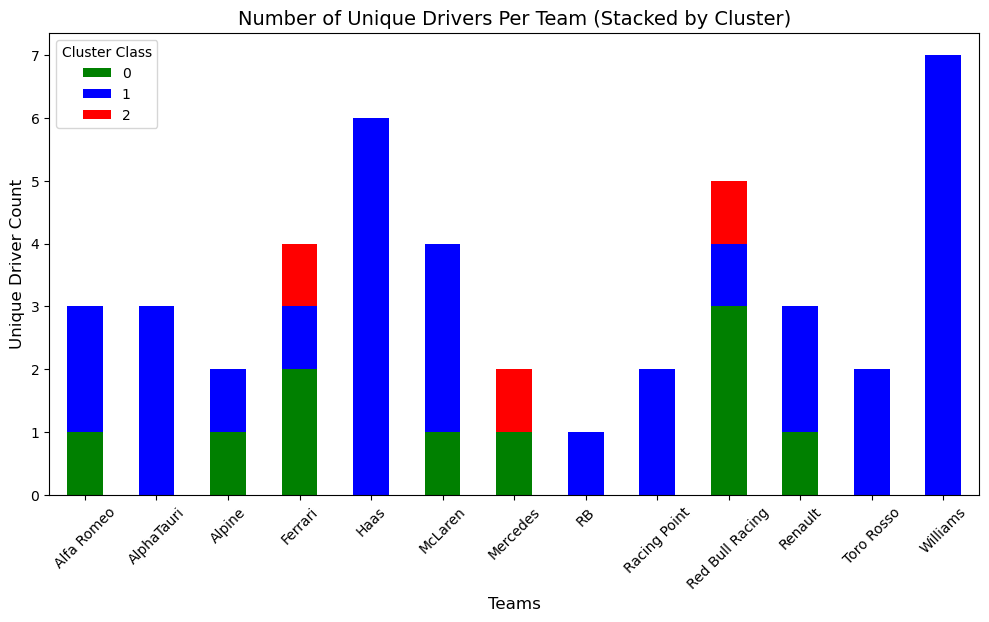

In [27]:

# Step 2: Count unique drivers per country and per cluster
team_cluster_counts = unique_drivers.groupby(["Team", "Cluster"]).size().unstack(fill_value=0)

# Step 3: Plot stacked bar chart
plt.figure(figsize=(12, 6))
colors = {0: "green", 1: "blue", 2: "red"}  # Custom color mapping
team_cluster_counts.plot(kind="bar", stacked=True, 
                            color=[colors[c] for c in team_cluster_counts.columns], 
                            figsize=(12, 6))

# Labels and title
plt.title("Number of Unique Drivers Per Team (Stacked by Cluster)", fontsize=14)
plt.xlabel("Teams", fontsize=12)
plt.ylabel("Unique Driver Count", fontsize=12)
plt.xticks(rotation=45)  # Rotate for readability
plt.legend(title="Cluster Class")

# Show the plot
plt.show()

This here shows the distribution of classes across the different teams in Formula 1. We made sure to remove any duplicates where drivers were in the same class across multiple years. However, we included when the same driver appeared in multiple classes over different years. Here we see that Williams and Haas have had the most drivers in our 6 year time frame for our data. They have also consistely produced middle class drivers, and have not produced any low class drivers. Red Bull Racing, has a high class driver but it also has the most low class drivers.

Lets see how much our variables influence the class prediction of our k-means model:

In [8]:
#Creating some sub-dataframes for 'Podium Percentage', 'Points', 'Highest Grid Position'
podium_to_class = all_drivers[['Podium Percentage', 'Cluster']]
prev_points_to_class = all_drivers[['Points', 'Cluster']]
grid_pos__to_class = all_drivers[['Highest Grid Position', 'Cluster']]

print(f"The correlation between Podium Percentage: {podium_to_class.corr().iloc[1,0]}")
print(f"The correlation between Previous Points Percentage: {prev_points_to_class.corr().iloc[1,0]}")
print(f"The correlation between Highest Grid Position Percentage: {grid_pos__to_class.corr().iloc[1,0]}")


The correlation between Podium Percentage: 0.03535578966409758
The correlation between Previous Points Percentage: 0.10583439063861579
The correlation between Highest Grid Position Percentage: 0.18425136924366953


In [9]:
def time_to_seconds(time_str):
    """Convert race time formats to absolute seconds."""
    if isinstance(time_str, str):
        if re.match(r'^\d{1,2}:\d{2}:\d{2}\.\d{3}$', time_str):  # hh:mm:ss.sss
            h, m, s = map(float, time_str.split(':'))
            return h * 3600 + m * 60 + s
        elif re.match(r'^\d{1,2}:\d{2}\.\d{3}$', time_str):  # mm:ss.sss
            m, s = map(float, time_str.split(':'))
            return m * 60 + s
    return None  # If not a valid time format, return None

def convert_time_column(all_races):
    """Convert all times to absolute seconds."""
    all_races = all_races.copy()

    # Identify the first-place finisher’s time
    first_place_row = all_races[all_races['Position'] == 1]
    if first_place_row.empty:
        raise ValueError("No first-place finisher found in dataset.")

    first_place_time_str = first_place_row.iloc[0]['Time/Retired']
    first_place_time = time_to_seconds(first_place_time_str)

    if first_place_time is None:
        raise ValueError("Invalid format for first-place finisher’s time.")

    def get_absolute_time(time_str):
    #"""Convert each row's time to absolute seconds."""
        if isinstance(time_str, str):
            if time_str.startswith('+') and 'lap' not in time_str:  # Time gaps (+XX.XXX)
                return first_place_time + float(time_str[1:])
            elif 'lap' in time_str:  # Lap deficits (+N laps)
                avg_lap_time = 90  # Adjust based on track or calculate from data
                laps = int(re.search(r'\d+', time_str).group())  # Extract number of laps
                return first_place_time + (laps * avg_lap_time)
            else:  # Direct race times (hh:mm:ss.sss or mm:ss.sss)
                return time_to_seconds(time_str)

        return None  # Handle unexpected cases


    # Apply conversion
    all_races['Time (seconds)'] = all_races['Time/Retired'].apply(get_absolute_time)

    return all_races

# Apply function and save results
all_races = convert_time_column(all_races)

# Show preview
all_races.head(n = 100)


,Track,Position,No,Team,Starting Grid,Points,Fastest Lap,Year,Time/Retired,Net Position,Time (seconds)
0,Australia,1,77,Mercedes,2,26.0,Yes,2019,1:25:27.325,1,5127.325
1,Australia,2,44,Mercedes,1,18.0,No,2019,+20.886,-1,5148.211
2,Australia,3,33,Red Bull Racing Honda,4,15.0,No,2019,+22.520,1,5149.845
3,Australia,4,5,Ferrari,3,12.0,No,2019,+57.109,-1,5184.434
4,Australia,5,16,Ferrari,5,10.0,No,2019,+58.230,0,5185.555
...,...,...,...,...,...,...,...,...,...,...,...
107,Monaco,8,23,Scuderia Toro Rosso Honda,10,4.0,No,2019,+55.200,2,5182.525
108,Monaco,9,3,Renault,6,2.0,No,2019,+60.894,-3,5188.219
109,Monaco,10,8,Haas Ferrari,13,1.0,No,2019,+61.034,3,5188.359
110,Monaco,11,4,McLaren Renault,12,0.0,No,2019,+66.801,1,5194.126


**EDA**

We were wondering if there would be any point difference between teams that have won a world championship vs teams who have not won a world championship.

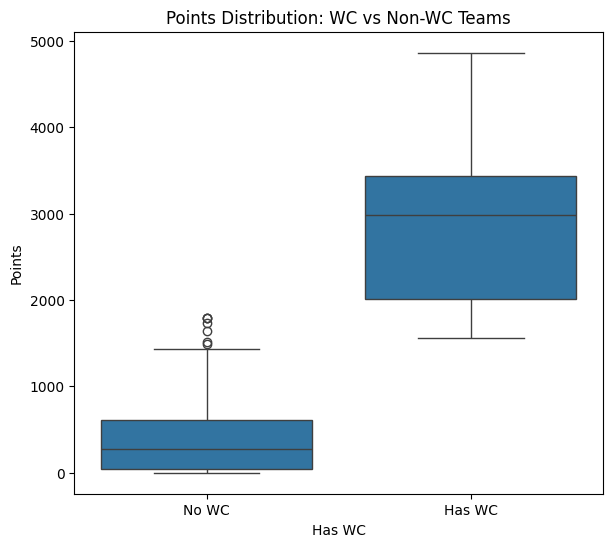

In [10]:
plt.figure(figsize=(15, 6))

# Points comparison
plt.subplot(1, 2, 1)
sns.boxplot(x='Has WC', y='Points', data=all_drivers)
plt.xticks([0, 1], ['No WC', 'Has WC'])
plt.title('Points Distribution: WC vs Non-WC Teams')

plt.show()


We can see here that generally those who have won world championships tend to have earned more points for the season. However, there are some instances where teams who haven't won a world championship have scored higher than those who have one a world championship which is demostrated by the outliers in the no world championship plot. 

Next we were interested to see if there is any relationship between podium percentage and if a team has won a world championship or not.

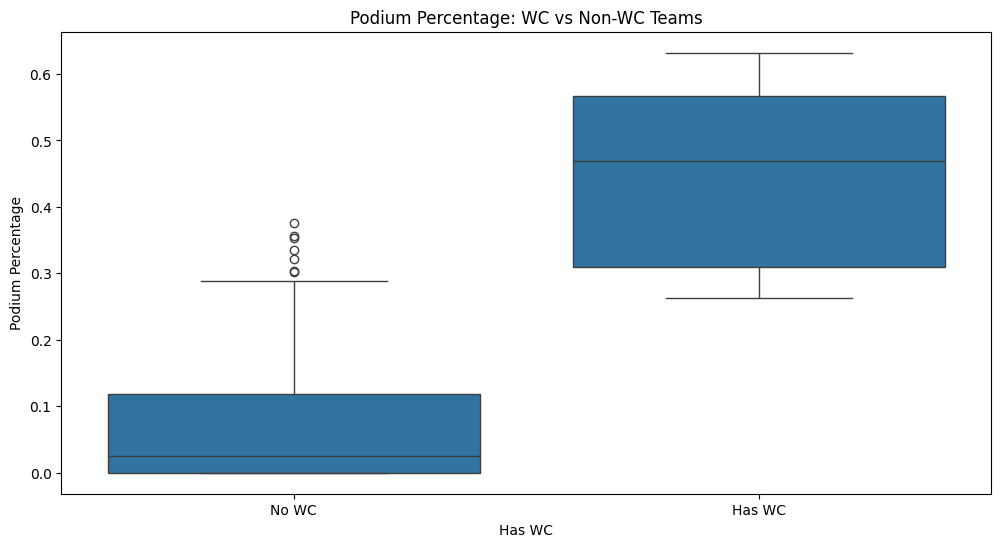

In [11]:
plt.figure(figsize=(12, 6))

# Podium Percentage comparison
sns.boxplot(x='Has WC', y='Podium Percentage', data=all_drivers)
plt.xticks([0, 1], ['No WC', 'Has WC'])
plt.title('Podium Percentage: WC vs Non-WC Teams')

#plt.tight_layout()
plt.show()

We can see that teams that have won world championships generally have a higher podium percentage. However, we do see more outliers here where some teams have higher podium percentages but just haven't won a world championship.

Next we wanted to see how lap times varied by each track, so we took the fastest lap times from each team for each track and compared them.
As we see, out of the variables we used to classify our points, it seems that the variable 'Highest Grid Position' has about an 18.42% correlation with the classes asigned. It is followed by their total career points until that season (~10.58%), and lastly, their podium percentage (~3.54%).

Based on this, we can say that the variables we chose have a positive correlation, however a mild one, with the strongest correlation being a somewhate positive correlation, and with the smallest correlation being a pretty weak positive correlation.

We wanted to see the relationship between points earned and number of grand prix (races entered)

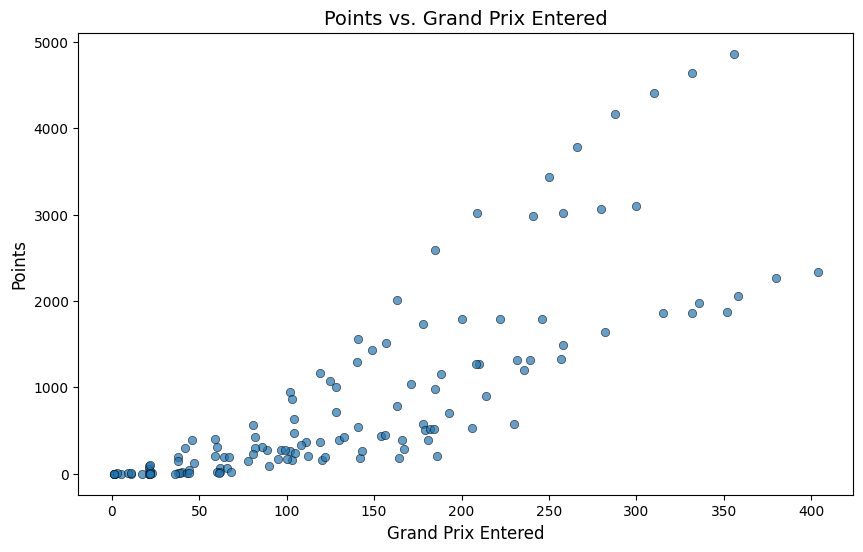

In [13]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_drivers, x="Grands Prix Entered", y="Points", alpha=0.7, edgecolor="black")

# Labels and title
plt.title("Points vs. Grand Prix Entered", fontsize=14)
plt.xlabel("Grand Prix Entered", fontsize=12)
plt.ylabel("Points", fontsize=12)

# Show the plot
plt.show()



We can see that there is a clear positive linear trend between points earned and number of grand prix entered. However, as the number of grand prix entered increases, we see a greater variance in the number of points scored. The points that show a greater looking slope could be due to teams that have been known to dominate the sport over the years. 

In [29]:
from scipy.stats import pearsonr

r_value, p_value = pearsonr(all_drivers["Grands Prix Entered"], all_drivers["Points"])
print(f"Pearson r: {r_value:.4f}, p-value: {p_value:.4e}")

Pearson r: 0.8059, p-value: 3.7069e-31


We have conducted a pearson correlation coefficient test on the relationship between Grand Prix Entered and Points. The coefficient has a value of 0.8059 which tells us there is a strong positive correlation between the two variables. We can now conclude that there is a strong indication that drivers do improve as they gain more experience in the sport.

Now we can see the point distribution across each team.

/var/folders/_g/y1cwj0bx0w1_xhq6250syd200000gn/T/ipykernel_6008/3317025503.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_races, x="Team", y="Points", palette="Set3")


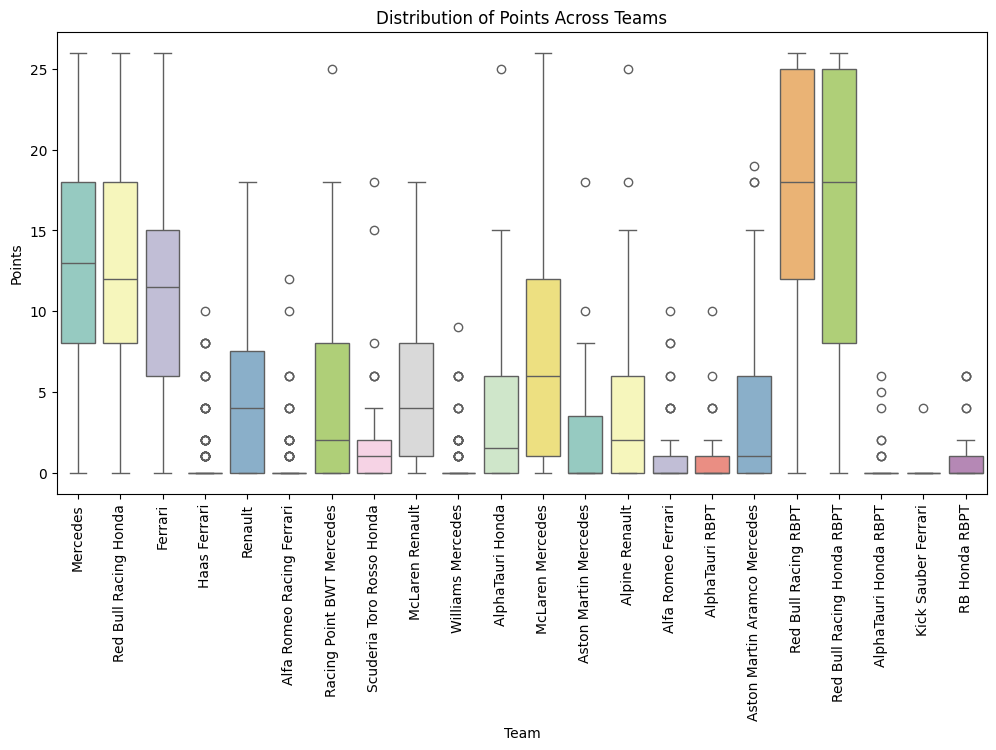

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_races, x="Team", y="Points", palette="Set3")
plt.xticks(rotation=90)
plt.title("Distribution of Points Across Teams")
plt.xlabel("Team")
plt.ylabel("Points")
plt.show()


We can observe that Red Bull tends to be the dominant team, scoring more points on average than other teams. The next closest team is mercedes, but on average it has substantially less points that red bull does. This could show a trend of red bull being the most dominant team in this sport.

Now we want to see the podium percentage across each team.

Now let's use K-Nearest-Neighbors to try and predict the driver's standings at the end of a season.

We will use 

In [15]:
unique_drivers = all_drivers['Number'].unique() 
unique_race_drivers = all_races['No'].unique()


unique_race_drivers

unique_drivers = all_drivers[all_drivers['Number'].isin(unique_race_drivers)]
unique_drivers

races_2019 = (all_races[all_races['Year'] == 2019])['Track'].unique()
races_2020 = (all_races[all_races['Year'] == 2020])['Track'].unique()
races_2021 = (all_races[all_races['Year'] == 2021])['Track'].unique()
races_2022 = (all_races[all_races['Year'] == 2022])['Track'].unique()
races_2023 = (all_races[all_races['Year'] == 2023])['Track'].unique()
races_2024 = (all_races[all_races['Year'] == 2024])['Track'].unique()

races_2019

consistent_races = np.array(["Australia", "Azerbaijan", "Spain", "Italy", "Great Britain", "Hungary", "Belgium", "Monaco", "Japan", "United States", "Brazil", "Abu Dhabi"])

knn_races = all_races[all_races['Track'].isin(consistent_races)]
knn_races

,Track,Position,No,Team,Starting Grid,Points,Fastest Lap,Year,Time/Retired,Net Position,Time (seconds),Fastest Lap (seconds)
0,Australia,1,77,Mercedes,2,26.0,Yes,2019,1:25:27.325,1,5127.325,None
1,Australia,2,44,Mercedes,1,18.0,No,2019,+20.886,-1,5148.211,None
2,Australia,3,33,Red Bull Racing Honda,4,15.0,No,2019,+22.520,1,5149.845,None
3,Australia,4,5,Ferrari,3,12.0,No,2019,+57.109,-1,5184.434,None
4,Australia,5,16,Ferrari,5,10.0,No,2019,+58.230,0,5185.555,None
...,...,...,...,...,...,...,...,...,...,...,...,...
471,Abu Dhabi,13,24,Kick Sauber Ferrari,15,0.0,No,2024,+1 lap,2,5217.325,None
472,Abu Dhabi,14,18,Aston Martin Aramco Mercedes,13,0.0,No,2024,+1 lap,-1,5217.325,None
473,Abu Dhabi,15,61,Alpine Renault,17,0.0,No,2024,+1 lap,2,5217.325,None
474,Abu Dhabi,16,20,Haas Ferrari,14,0.0,Yes,2024,+1 lap,-2,5217.325,None


In [16]:

unique_drivers = unique_drivers
unique_drivers["Avg Fastest Lap"] = 0

xval = (knn_races[knn_races['Year'] == 2019])
y = list((xval[ xval['No'] == 44.0])["Fastest Lap"])

years = [2019, 2020, 2021, 2022, 2023, 2024]
driverNumbers = list(unique_drivers.iloc[:,0])

fastestLapSum = 0
for k in driverNumbers:
    for j in years:
        xval = (knn_races[knn_races['Year'] == j])
        y = list((xval[ xval['No'] == k])["Fastest Lap"])
        for i in range(0,len(y)):
            if(y[i] == "Yes"):
                fastestLapSum += 1   
        for m in range(len(unique_drivers)):
            if((unique_drivers.iloc[m,0] == k) & (unique_drivers.iloc[m,8] == j)):
                unique_drivers.iloc[m,12] = fastestLapSum/len(xval)
        fastestLapSum = 0

print(unique_drivers.iloc[:,12])
unique_drivers.columns

/var/folders/_g/y1cwj0bx0w1_xhq6250syd200000gn/T/ipykernel_6008/2053261102.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02336448598130841' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  unique_drivers.iloc[m,12] = fastestLapSum/len(xval)


0     0.023364
1     0.004673
2     0.004673
3     0.009346
4     0.004673
        ...   
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
Name: Avg Fastest Lap, Length: 132, dtype: float64


Index(['Number', 'Team', 'Country', 'Podiums', 'Points', 'Grands Prix Entered',
       'World Championships', 'Highest Grid Position', 'Year',
       'Podium Percentage', 'Has WC', 'Cluster', 'Avg Fastest Lap',
       'Avg Net Position'],
      dtype='object')

In [17]:
unique_drivers = unique_drivers
unique_drivers["Avg Net Position"] = 0
sumNetPosition = 0

xval = (knn_races[knn_races['Year'] == 2019])
y = list((xval[ xval['No'] == 44.0])["Net Position"])

years = [2019, 2020, 2021, 2022, 2023, 2024]
driverNumbers = list(unique_drivers.iloc[:,0])

for k in driverNumbers:
    for j in years:
        xval = (knn_races[knn_races['Year'] == j])
        y = list((xval[ xval['No'] == k])["Net Position"])
        for i in range(0,len(y)):
            sumNetPosition += y[i]  
        for m in range(len(unique_drivers)):
            if((unique_drivers.iloc[m,0] == k) & (unique_drivers.iloc[m,8] == j)):
                unique_drivers.iloc[m,13] = sumNetPosition/len(xval)
        sumNetPosition = 0
print(unique_drivers.iloc[:,13])

/var/folders/_g/y1cwj0bx0w1_xhq6250syd200000gn/T/ipykernel_6008/934463167.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.014018691588785047' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  unique_drivers.iloc[m,13] = sumNetPosition/len(xval)


0     0.014019
1     0.056075
2     0.046729
3    -0.023364
4    -0.168224
        ...   
19    0.060748
20    0.004673
21   -0.028037
22    0.000000
23    0.009346
Name: Avg Net Position, Length: 132, dtype: float64


Now that we have cleaned our data, let's start our KNN Regression:

In [80]:
standings = pd.read_csv("Data/standings.csv")
standings.head()

X_train, X_test, y_train, y_test = train_test_split(unique_drivers[["Avg Net Position", "Avg Fastest Lap", "Cluster", "Podium Percentage", "Has WC", "Points"]], standings[["Position"]].fillna(0), test_size=0.3, random_state=0)

accuracy = []

for k in range(1, 21):
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train, y_train)
    print(f'Score for k={k}: {knn_regressor.score(X_test, y_test)}')
    accuracy.append(knn_regressor.score(X_test, y_test))


Score for k=1: 0.38325417994925515
Score for k=2: 0.5836315138897925
Score for k=3: 0.6298946790131489
Score for k=4: 0.556998568733329
Score for k=5: 0.4886734760262833
Score for k=6: 0.4351195252242679
Score for k=7: 0.47405596810319983
Score for k=8: 0.47305396525925447
Score for k=9: 0.4545203369179255
Score for k=10: 0.42321904885823947
Score for k=11: 0.43530561737220097
Score for k=12: 0.4333485134343895
Score for k=13: 0.43385665544776364
Score for k=14: 0.4426026216875404
Score for k=15: 0.4341292043458461
Score for k=16: 0.40852498210916666
Score for k=17: 0.4060243315334071
Score for k=18: 0.40067314511614394
Score for k=19: 0.3908646548317145
Score for k=20: 0.36292043458460754


Text(0, 0.5, 'Accuracy')

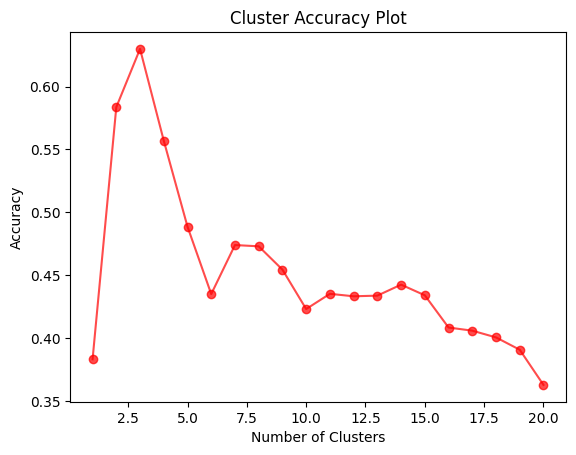

In [94]:
cluster_accuracy = np.column_stack((accuracy, np.arange(1, 21)))
plt.plot(cluster_accuracy[:, 1], cluster_accuracy[:, 0], marker='o', color='r', linestyle='-', alpha=0.7)

plt.title('Cluster Accuracy Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')

i23oukwejahsfbociqulwkaejmshdnrfoiualkjsn

In [127]:
standings_2024 = standings[standings["Year"] == 2024]
X_pred_vals_2024 = unique_drivers[unique_drivers["Year"] == 2024]

max_2024 = X_pred_vals_2024[X_pred_vals_2024["Number"] == 1]
norris_2024 = X_pred_vals_2024[X_pred_vals_2024["Number"] == 4]
leclerc_2024 = X_pred_vals_2024[X_pred_vals_2024["Number"] == 16]

knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train, y_train)

max_pred = knn_regressor.predict(max_2024[["Avg Net Position", "Avg Fastest Lap", "Cluster", "Podium Percentage", "Has WC", "Points"]])
norris_pred = knn_regressor.predict(norris_2024[["Avg Net Position", "Avg Fastest Lap", "Cluster", "Podium Percentage", "Has WC", "Points"]])
leclerc_pred = knn_regressor.predict(leclerc_2024[["Avg Net Position", "Avg Fastest Lap", "Cluster", "Podium Percentage", "Has WC", "Points"]])

print(max_pred)
print(norris_pred)
print(leclerc_pred)

#2024,1,Max Verstappen,1,NED,Red Bull Racing Honda RBPT,437
#2024,2,Lando Norris,4,GBR,McLaren Mercedes,374
#2024,3,Charles Leclerc,16,MON,Ferrari,356

true_max = standings_2024[standings_2024["Number"] == 1]
print(true_max["Position"].iloc[0])

true_norris = standings_2024[standings_2024["Number"] == 4]
print(true_norris["Position"].iloc[0])

true_leclerc = standings_2024[standings_2024["Number"] == 16]
print(true_leclerc["Position"].iloc[0])
#print(standings_2024[standings_2024["Number"] == 1])


[[10.]]
[[5.33333333]]
[[2.33333333]]
1
2
3


wgurekqdjlwqnlhueir2q4efjknwdslwojeirhufjbdn 

/var/folders/l_/7jk3kgwj03b5gs05k2fpbrsh0000gn/T/ipykernel_27121/2545411425.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_podium, x="Podium Percentage", y="Team", palette="viridis")


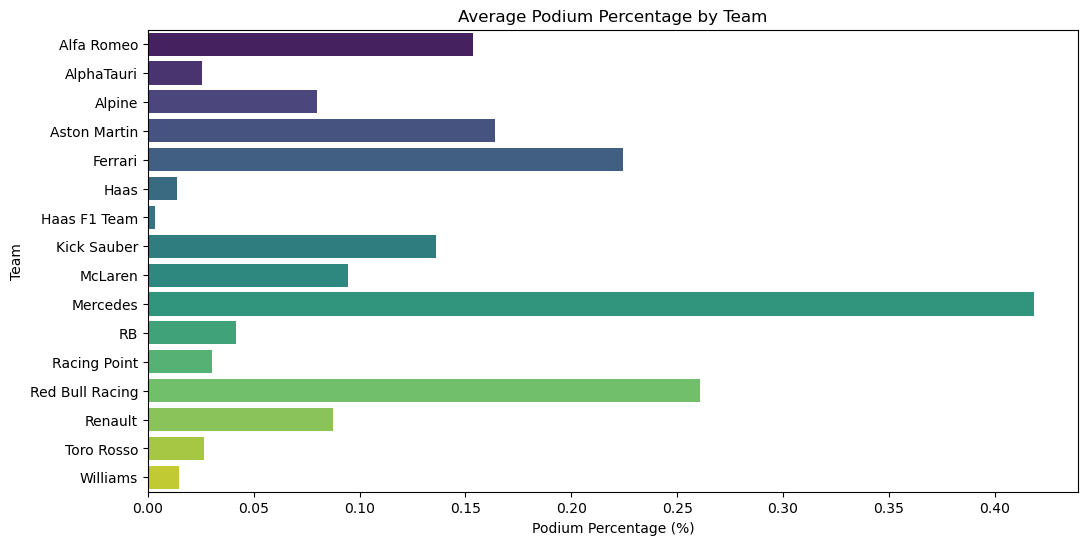

In [ ]:
team_podium = all_drivers.groupby("Team")["Podium Percentage"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=team_podium, x="Podium Percentage", y="Team", palette="viridis")
plt.title("Average Podium Percentage by Team")
plt.xlabel("Podium Percentage (%)")
plt.ylabel("Team")
plt.show()


Here we observe that Mercedes actually has a much higher podium percentage than red bull does. This is interesting because as we saw above, red bull racing had the highest points on average. Here, Ferrari also has a close podium percentage to red bull but Ferrari generally scores less points than red bull as we saw in the plot above.

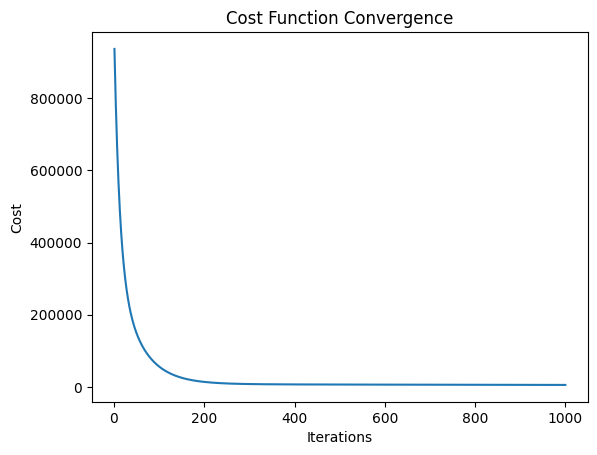

Predictions: [3616.78260473 1264.41321486  993.69884771  484.69662795 2979.55947498
  247.36561014  113.23210345   23.5804084   968.49135767  569.32676888]
Mean Squared Error: 10778.050403940499


In [19]:
# Assuming 'all_drivers' is your dataframe and it contains the relevant features
features = all_drivers[['Podium Percentage', 'Podiums', 'Points', 'Grands Prix Entered', 'World Championships']]
target = all_drivers['Points']

# Normalize the features (standardization)
features_scaled = (features - features.mean()) / features.std()

# Convert to numpy arrays for matrix operations
X = np.c_[np.ones(features_scaled.shape[0]), features_scaled.values]  # Add intercept term (bias)
y = target.values

# Gradient Descent function
def gradient_descent(X, y, learning_rate=0.01, iterations=1000):
    m = len(y)  # number of training examples
    theta = np.zeros(X.shape[1])  # Initialize parameters (weights)
    cost_history = []

    for _ in range(iterations):
        prediction = np.dot(X, theta)  # Hypothesis
        error = prediction - y
        gradient = (1 / m) * np.dot(X.T, error)  # Gradient calculation
        theta -= learning_rate * gradient  # Update parameters
        cost = (1 / (2 * m)) * np.sum(error**2)  # Compute cost
        cost_history.append(cost)

    return theta, cost_history

# Run gradient descent
theta, cost_history = gradient_descent(X, y, learning_rate=0.01, iterations=1000)

# Plot the cost function over iterations
plt.plot(range(1, len(cost_history) + 1), cost_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function Convergence')
plt.show()

# Make predictions on the training set
predictions = np.dot(X, theta)
print("Predictions:", predictions[:10])

# Evaluate the model (Mean Squared Error)
mse = np.mean((predictions - y) ** 2)
print("Mean Squared Error:", mse)
